#Создание модели для предсказания "Appliances" и "lights" на основе датасета “Appliances Energy Prediction”.

##Импорт бибилиотек

In [169]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

##Data import and preparation

In [170]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

In [171]:
pd.set_option('display.max_columns', None)

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

###EDA and feature engineering

In [173]:
# creating new features from date column

df['date'] = pd.to_datetime(df['date'])

df['month'] = df['date'].dt.month

df['weekday'] = df['date'].dt.weekday

df['hour'] = df['date'].dt.hour

df['day_of_week'] = df['date'].dt.day_name()

df['week_of_month'] = (df['date'].dt.day-1) // 7 + 1

In [174]:
# analyse the time distribution of the target features

appliancesByHour = df.groupby('hour')[['lights', 'Appliances']].mean()['Appliances']
lightsByHour = df.groupby('hour')[['lights', 'Appliances']].mean()['lights']

appliancesByWeekday = df.groupby('weekday')[['lights', 'Appliances']].mean()['Appliances']
lightsByWeekday = df.groupby('weekday')[['lights', 'Appliances']].mean()['lights']

appliancesByMonth = df.groupby('month')[['lights', 'Appliances']].mean()['Appliances']
lightsByMonth = df.groupby('month')[['lights', 'Appliances']].mean()['lights']

Text(0.5, 1.0, 'Lights')

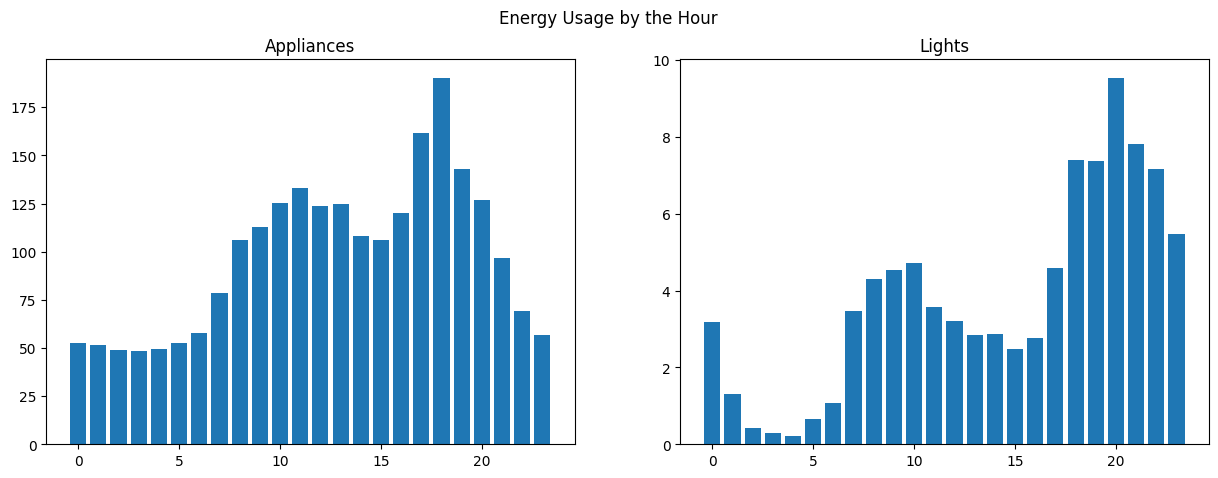

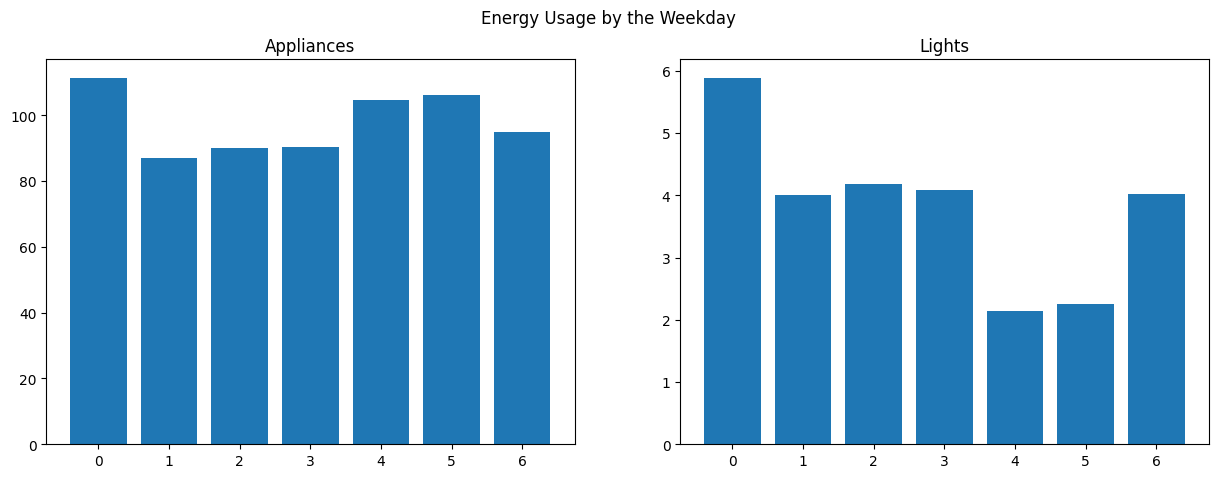

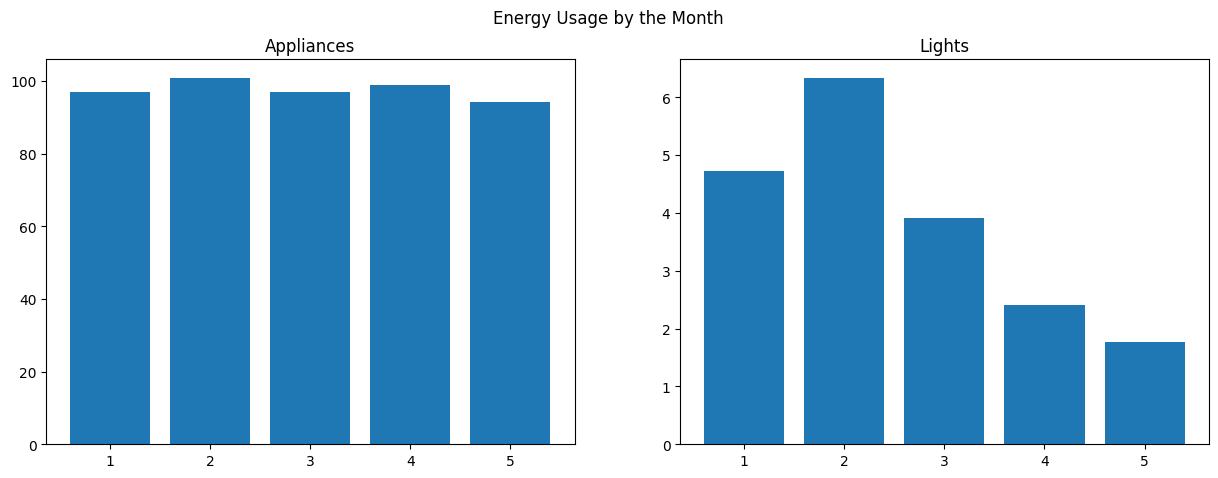

In [175]:
fig, axes = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Energy Usage by the Hour')
axes[0].bar(x = appliancesByHour.index, height = appliancesByHour.values)
axes[1].bar(x = lightsByHour.index, height = lightsByHour.values)
axes[0].set_title('Appliances')
axes[1].set_title('Lights')

fig, axes = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Energy Usage by the Weekday')
axes[0].bar(x = appliancesByWeekday.index, height = appliancesByWeekday.values)
axes[1].bar(x = lightsByWeekday.index, height = lightsByWeekday.values)
axes[0].set_title('Appliances')
axes[1].set_title('Lights')

fig, axes = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Energy Usage by the Month')
axes[0].bar(x = appliancesByMonth.index, height = appliancesByMonth.values)
axes[1].bar(x = lightsByMonth.index, height = lightsByMonth.values)
axes[0].set_title('Appliances')
axes[1].set_title('Lights')

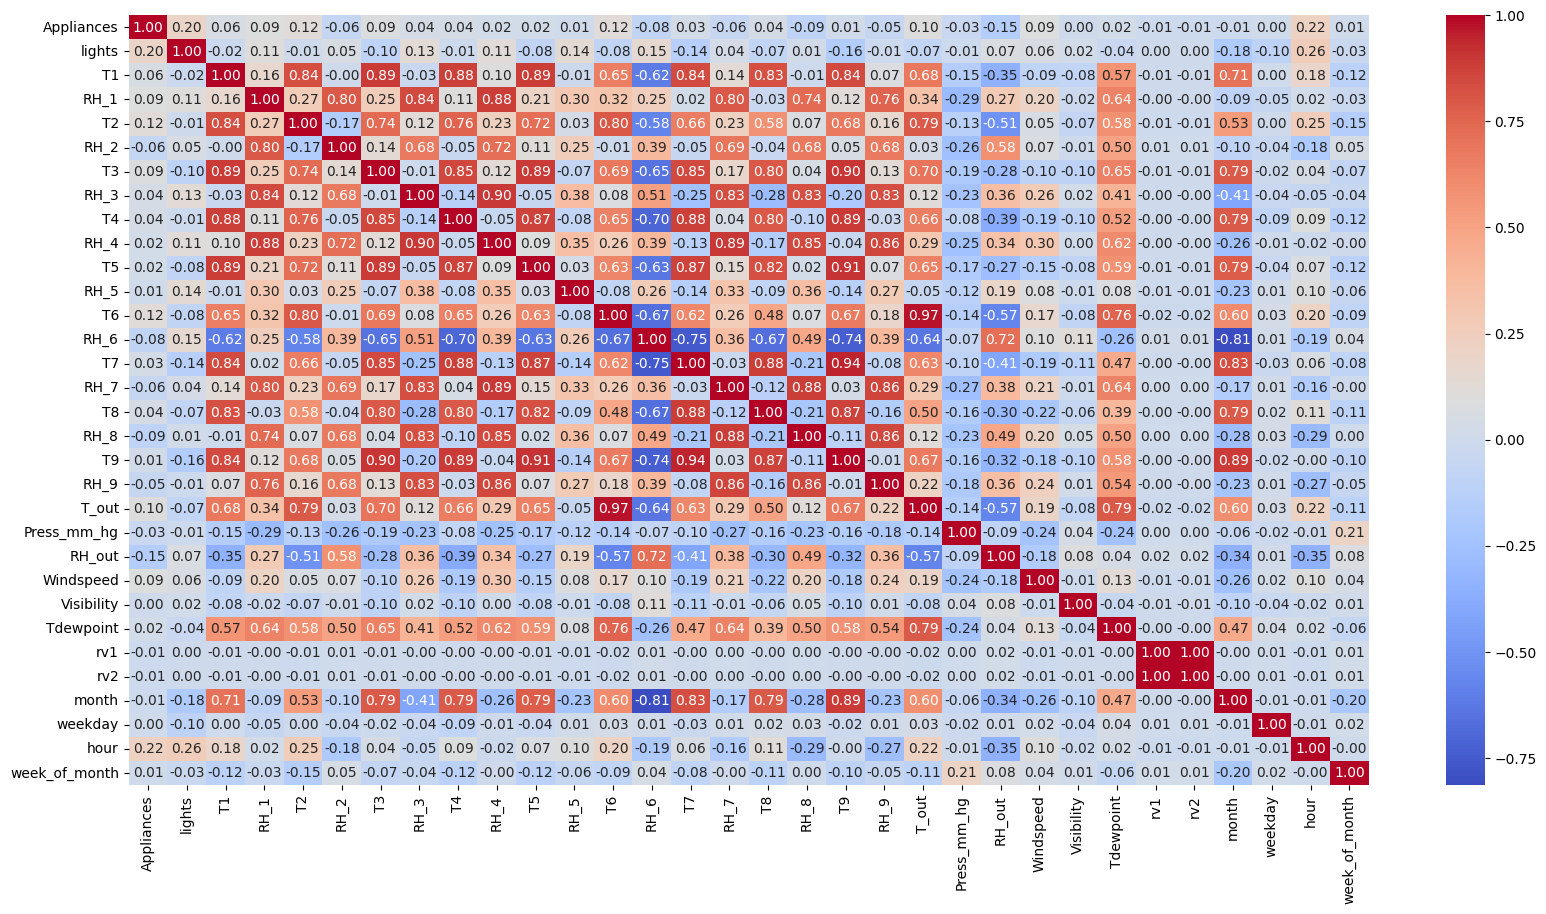

In [176]:
# creating a correlation matrix to check for multicollinearity

plt.figure(figsize=(20, 10))
numerical_data = df.select_dtypes(include='number')
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

We may notice that temperature features (T1 to T9 in rooms and T_out from the weather station) are highly correlated. Same goes for the humidity RH_i feature. Let's train the model limiting the temperature and humidity feature to T6 and RH_6, since they have the highest correlation with the target features.

###Outliers in target variables

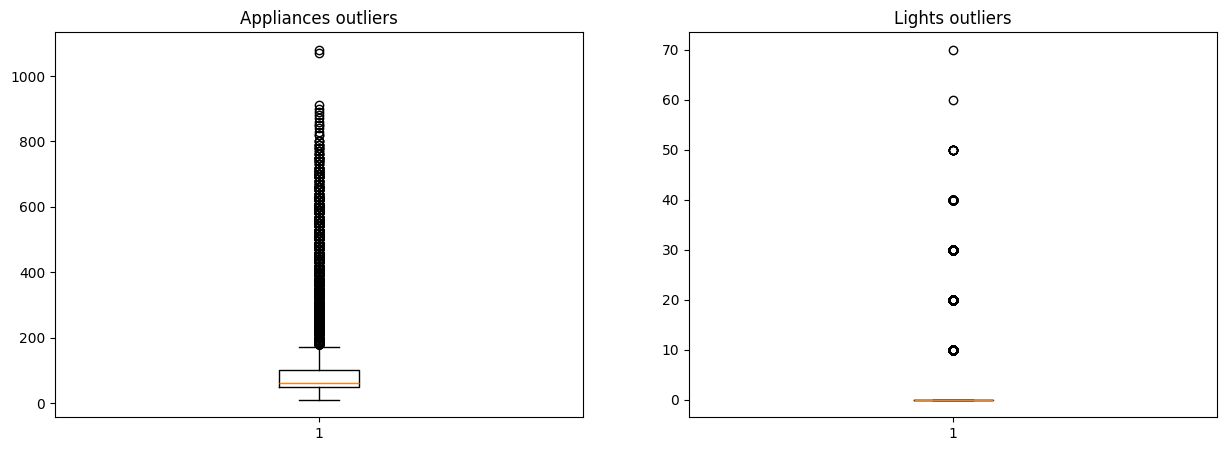

In [177]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].boxplot(df['Appliances'])
ax[0].set_title('Appliances outliers')

ax[1].boxplot(df['lights'])
ax[1].set_title('Lights outliers')

plt.show()

We can see a lot of outliers for the Appliances, however, it is hard to say the same for lights: 77 % of the values is equal to 0.

In [178]:
(df['lights'] == 0).mean().round(decimals = 3)

0.773

Let's try DBSCAN outlier detection algorythm to remove the outliers. We also consider the dependance on hour and day of the week, since they must influence the energy consumption in the house.

In [179]:
X = df[['weekday', 'hour', 'Appliances', 'lights']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

df['outlier'] = labels
df_filtered = df[df['outlier'] != -1]
df_filtered = df_filtered.drop(columns=['outlier'])

print("Outliers removed:", df.shape[0] - df_filtered.shape[0])

Outliers removed: 748


##Dataset splitting

Check if feature engineering improves the model preformance. Create datasets with dropped collinear features and deleted outliers.

In [180]:
X_full = df.drop(['date', 'lights', 'Appliances','rv1', 'rv2', 'day_of_week'], axis = 1)
y_full = df[['lights', 'Appliances']]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train_full_scaled = scaler.fit_transform(X_train_full)

X_test_full_scaled = scaler.transform(X_test_full)

In [181]:
X_filtered = df_filtered.drop(['date', 'lights', 'Appliances','rv1', 'rv2', 'day_of_week',
                   'T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'T8', 'T9', 'T_out', 'RH_1',
                   'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_8', 'RH_9', 'RH_out'], axis = 1)

y_filtered = df_filtered[['lights', 'Appliances']]

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)

X_test_filtered_scaled = scaler.transform(X_test_filtered)

##Multioutput regressor fitting

In [182]:
def evaluate_multioutput_models(models, train_test_data, metric='mae'):
    """
    Evaluates different models on predetermined train and test datasets using MultiOutputRegressor.

    Parameters:
    - models: dict, where keys are model names and values are model instances (e.g., {'Linear Regression': LinearRegression()}).
    - train_test_data: list of tuples (train_X, train_y, test_X, test_y) for different train-test splits.
    - metric: str, the metric for evaluation ('mae', 'mse', or 'r2').

    Returns:
    - results: dict, with model names as keys and lists of scores for each dataset as values.
    """
    results = {model_name: [] for model_name in models.keys()}

    # Define metric function
    metric_fn = {
        'mae': mean_absolute_error,
        'mse': mean_squared_error,
        'r2': r2_score
    }.get(metric)

    # Evaluate each model on each dataset
    for model_name, model in models.items():
        multi_output_model = MultiOutputRegressor(model)
        for train_X, train_y, test_X, test_y in train_test_data:
            # Fit model
            multi_output_model.fit(train_X, train_y)

            # Predict and calculate metric
            predictions = multi_output_model.predict(test_X)
            score = metric_fn(test_y, predictions, multioutput='uniform_average')  # Use uniform average for multioutput

            # Append score
            results[model_name].append(score)

    return results,


In [183]:
evaluate_multioutput_models(models = {'Linear Regression': LinearRegression(), 'Decision Tree': DecisionTreeRegressor()},
                train_test_data = [(X_train_full_scaled, y_train_full, X_test_full_scaled, y_test_full), (X_train_filtered_scaled, y_train_filtered, X_test_filtered_scaled, y_test_filtered)],
                metric = 'r2')

({'Linear Regression': [0.20866924991780944, 0.09521866647867905],
  'Decision Tree': [0.6676625960231719, 0.3902547736458644]},)

In [184]:
evaluate_multioutput_models(models = {'Linear Regression': LinearRegression(), 'Decision Tree': DecisionTreeRegressor()},
                train_test_data = [(X_train_full_scaled, y_train_full, X_test_full_scaled, y_test_full), (X_train_filtered_scaled, y_train_filtered, X_test_filtered_scaled, y_test_filtered)],
                metric = 'mse')

({'Linear Regression': [4189.639876002953, 2875.7703474104896],
  'Decision Tree': [2362.794527489232, 2218.996840442338]},)

R2 scores drop significatly when fitting the regressor with filtered data. Let's consider all features and see if result is the same:

In [189]:
X_filtered_all_features = df_filtered.drop(['date', 'lights', 'Appliances','rv1', 'rv2', 'day_of_week'], axis = 1)

y_filtered = df_filtered[['lights', 'Appliances']]

X_train_filtered_all_features, X_test_filtered_all_features, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train_filtered_all_features_scaled = scaler.fit_transform(X_train_filtered_all_features)

X_test_filtered_all_features_scaled = scaler.transform(X_test_filtered_all_features)

In [190]:
evaluate_multioutput_models(models = {'Linear Regression': LinearRegression(), 'Decision Tree': DecisionTreeRegressor()},
                train_test_data = [(X_train_full_scaled, y_train_full, X_test_full_scaled, y_test_full), (X_train_filtered_all_features_scaled, y_train_filtered, X_test_filtered_all_features_scaled, y_test_filtered)],
                metric = 'r2')

({'Linear Regression': [0.20866924991780944, 0.09521866647867905],
  'Decision Tree': [0.6587567601003377, 0.3753219922239354]},)

In [187]:
evaluate_multioutput_models(models = {'Linear Regression': LinearRegression(), 'Decision Tree': DecisionTreeRegressor()},
                train_test_data = [(X_train_full_scaled, y_train_full, X_test_full_scaled, y_test_full), (X_train_filtered_scaled, y_train_filtered, X_test_filtered_scaled, y_test_filtered)],
                metric = 'mse')

({'Linear Regression': [4189.639876002953, 2875.7703474104896],
  'Decision Tree': [2429.8581200912085, 2170.5634544497107]},)

Apparently, excluding collinear features does not heavily influence the performance. Further research into the data needed to improve the scores.